# 0) 概論
### このNotebookでは、大まかに以下の方法で株価など時系列データの未来予測を行う
翌日の株価の予想を主題とする。  
一年ほどを掛けて精度を上げていく予定。いずれは自動売買の予想モデルとして使用したい。  
2026年夏頃の完成を目指す。  
seedをあえて固定していないので、実行ごとに結果が多少変わります。
#### 論文を参考にした以下の５つのモデルでそれぞれ予測を行う  
- LSTM
- Bidirectional LSTM + Attention
- Transformer
- Informer
- Autoformer

最終的には明日データ最終日の翌日）の株価が上がるor下がるの分類として出力するつもりだが、まずは株価の価格を回帰として出力させる。  
この段階で各モデルが55％程度の方向性正解率を出せれば十分。
#### ５つのモデルの精度を考慮しつつ、結果をアンサンブルする
上記５モデルが未完成のため、現状は机上の空論のみで簡易なコードを作成。  
５モデルの出力に加えて、相関・逆相関のある金融の指数を特徴量として加える。  
アンサンブルのメタモデルには、学習性能を弱めたRandomForestを使おうと考えている。  
最終的に60％程度の方向性正解率を出せれば理想的だと考えている。

## 準備としてサンプルの株価を取得
Googleの株価をstooqより取得し実験

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import pandas_datareader.data as pdr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Input, layers, models, Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, BatchNormalization, LayerNormalization, Activation, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

2025-06-30 18:25:39.678114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751307939.967333      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751307940.049305      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ticker_symbole = 'GOOG.US' 
start = '2014-01-01'
end   = datetime.now()
data = pdr.DataReader(ticker_symbole, 'stooq', start=start, end=end)

# dataには新しい順に数値が入っている 時系列にしたいので、逆順にソート
data = data.iloc[::-1]  
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-03-27,28.4000,28.4000,27.6460,27.9230,261040
2014-03-28,28.0600,28.3215,27.9335,27.9995,820060
2014-03-31,28.3445,28.3500,27.8465,27.8485,215440
2014-04-01,27.9355,28.4225,27.9355,28.3580,158640
2014-04-02,29.9995,30.2415,28.1095,28.3500,2933940


主要な指標の求め方を忘備録代わりに書いておく。  
MACDとRSIは特徴量として予測に使用する。

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


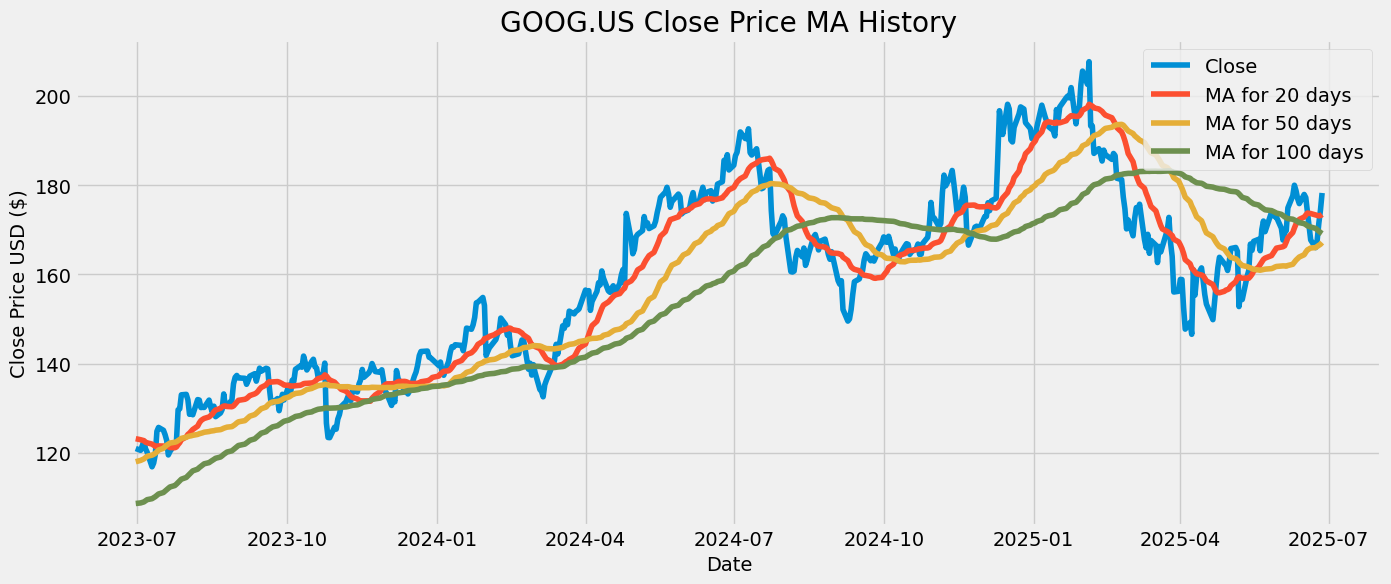

In [3]:
#-- 移動平均 --#
ma_day = [20, 50, 100]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(ma).mean()

#-- MACD --#
short_period = 12
long_period = 26
signal_period = 9
# 短期と長期のEMA（指数平滑移動平均）を計算
data['EMA_short'] = data['Close'].ewm(span=short_period, adjust=False).mean()
data['EMA_long'] = data['Close'].ewm(span=long_period, adjust=False).mean()
# MACDラインを計算
data['MACD'] = data['EMA_short'] - data['EMA_long']
# シグナルラインを計算
data['Signal'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
# MACDヒストグラムを計算
data['MACD_Histogram'] = data['MACD'] - data['Signal']

#-- RSI --#
def calc_rsi(period, delta):
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rsi = 100 *(avg_gain/(avg_gain+avg_loss))
    return rsi
delta = data['Close'].diff()
data['RSI9'] = calc_rsi(9, delta)
data['RSI14'] = calc_rsi(14, delta)

plt.figure(figsize=(15, 6))
plt.title(ticker_symbole + ' Close Price MA History')
plt.plot(data['Close'][-500:])           # 最新500日のみ表示
plt.plot(data['MA for 20 days'][-500:])
plt.plot(data['MA for 50 days'][-500:])
plt.plot(data['MA for 100 days'][-500:])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days'], loc='upper right')
plt.show()

In [4]:
data.head(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Open,High,Low,Close,Volume,MA for 20 days,MA for 50 days,MA for 100 days,EMA_short,EMA_long,MACD,Signal,MACD_Histogram,RSI9,RSI14
Date,,,,,,,,,,,,,,,
2014-03-27,28.4000,28.4000,27.6460,27.9230,261040,NaN,NaN,NaN,27.923000,27.923000,0.000000,0.000000,0.000000,NaN,NaN
2014-03-28,28.0600,28.3215,27.9335,27.9995,820060,NaN,NaN,NaN,27.934769,27.928667,0.006103,0.001221,0.004882,NaN,NaN
2014-03-31,28.3445,28.3500,27.8465,27.8485,215440,NaN,NaN,NaN,27.921497,27.922728,-0.001231,0.000730,-0.001961,NaN,NaN
2014-04-01,27.9355,28.4225,27.9355,28.3580,158640,NaN,NaN,NaN,27.988651,27.954971,0.033681,0.007320,0.026360,NaN,NaN
2014-04-02,29.9995,30.2415,28.1095,28.3500,2933940,NaN,NaN,NaN,28.044243,27.984232,0.060011,0.017858,0.042153,NaN,NaN
2014-04-03,28.4925,29.3640,28.2065,28.4870,101750000,NaN,NaN,NaN,28.112360,28.021474,0.090886,0.032464,0.058422,NaN,NaN
2014-04-04,28.7325,28.8885,27.1500,27.1570,127552000,NaN,NaN,NaN,27.965381,27.957439,0.007942,0.027560,-0.019617,NaN,NaN
2014-04-07,27.0370,27.4240,26.3575,26.9075,87374340,NaN,NaN,NaN,27.802630,27.879666,-0.077035,0.006641,-0.083676,NaN,NaN
2014-04-08,27.1535,27.7500,27.0805,27.7450,62971260,NaN,NaN,NaN,27.793764,27.869691,-0.075926,-0.009873,-0.066054,47.302213,NaN


### 予測に利用するデータセットの準備
データセットに含めるのは以下の６個  
　Close（終値），Volume（出来高），MACD_Histogram，Signal，RSI9，RSI14  
Closeはリターン（変化率）に直して使用する。

In [5]:
# datasetとして利用するClose(終値)
dataset = data[['Close', 'Volume', 'MACD_Histogram', 'Signal', 'RSI9', 'RSI14']]
#-- リターン（単純変化率） --#
dataset['returns'] = dataset['Close'].pct_change()

dataset = dataset.iloc[20:]
dataset.head()

/tmp/ipykernel_13/872747020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['returns'] = dataset['Close'].pct_change()


,Close,Volume,MACD_Histogram,Signal,RSI9,RSI14,returns
Date,,,,,,,
2014-04-25,25.8090,41939940,-0.132182,-0.303998,40.836299,40.586592,-0.017100
2014-04-28,25.8575,66511300,-0.134369,-0.337591,40.113212,42.455813,0.001879
2014-04-29,26.3850,53836980,-0.091954,-0.360579,44.819820,39.772898,0.020400
2014-04-30,26.3330,34928100,-0.060579,-0.375724,27.120980,34.981568,-0.001971
2014-05-01,26.5675,38008220,-0.019348,-0.380561,45.206862,45.483628,0.008905


## データの準備

In [6]:
# 特徴量列の選択
features = ['returns', 'Volume', 'MACD_Histogram', 'Signal', 'RSI9', 'RSI14']
feature_data = dataset[features].copy()

# スケーリング
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# StandardScaler：returns, MACD_Histogram, Signal（正負ありデータ）
standard_cols = ['returns', 'MACD_Histogram', 'Signal']
feature_data[standard_cols] = standard_scaler.fit_transform(feature_data[standard_cols])

# MinMaxScaler：Volume, RSI9, RSI14（非負データ）
minmax_cols = ['Volume', 'RSI9', 'RSI14']
feature_data[minmax_cols] = minmax_scaler.fit_transform(feature_data[minmax_cols])

#---------- トレーニングデータの作成 ----------# 
# 前から80%をトレーニングデータとして扱う
train_data_len = int(np.ceil(len(feature_data) * 0.8))
# どれくらいの期間をもとに予測するか
window_size = 60  # 60days

# 特徴量すべて（6列）をスライスし、x_train, y_trainを作成
x_train, y_train = [], []  # type: list 変換の必要あり

for i in range(window_size, train_data_len):
    x_train.append(feature_data.iloc[i-window_size:i].to_numpy())
    y_train.append(feature_data.iloc[i]['returns'])  # 目的変数は returns（正規化済）

# ndarrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)

# LSTM入力用の shape に変形
# (samples, timesteps, features)
print("x_train shape:", x_train.shape)  # → (train_samples, window_size, 6)
print("y_train shape:", y_train.shape)  # → (train_samples,)

#---------- テストデータの作成 ----------#
test_data = feature_data.iloc[train_data_len - window_size:].copy()  # 60日分前から必要

x_test, y_test = [], []  # type: list 変換の必要あり

for i in range(window_size, len(test_data)):
    x_test.append(test_data.iloc[i-window_size:i].to_numpy())
    y_test.append(test_data.iloc[i]['returns'])  # 予測対象は returns（正規化済）

# ndarrayに変換
x_test, y_test = np.array(x_test), np.array(y_test)

# shape 確認（samples, timesteps, features）
print("x_test shape:", x_test.shape)   # (テストサンプル数, window_size, 6)
print("y_test shape:", y_test.shape)   # (テストサンプル数,)


# 後の逆変換用に returns 専用スケーラー保存
returns_scaler = StandardScaler()
returns_scaler.fit(dataset[['returns']])  # 正規化前の 'returns' に対してフィット


#---------- アンサンブルのための各モデルの予測を入れる DataFlame ----------#
preds = pd.DataFrame(index=test_data.iloc[window_size:].index, columns=[])
#---------- アンサンブルのための正解データを入れる DataFlame ----------#
returns = dataset['returns'].iloc[train_data_len:].copy()
#---------- 明日予測（データ最終日の翌日）のための入力（ラスト60日のデータ） ----------#
final_input = test_data.iloc[-window_size:].copy().to_numpy().reshape(1, window_size, len(features))
#---------- 各モデルの明日予測を入れる DataFlame ----------#
final_preds = pd.DataFrame(index=['new_day'], columns=[])

x_train shape: (2189, 60, 6)
y_train shape: (2189,)
x_test shape: (562, 60, 6)
y_test shape: (562,)


# 1) LSTM
過去60日分のデータを学習して61日目のデータを予想する、ということを繰り返して学習するモデル  
論文「Stock Market Prediction Using LSTM Recurrent Neural Network」に近い実装となっていそうな「mwitiderrick/stockprice」を参考  
mwitiderrick/stockprice: https://github.com/mwitiderrick/stockprice/blob/master/TATA%20.ipynb

## LSTMモデルの実装
４層のLSTMの間にDropout(0.2)を挟む
最適化アルゴリズムにadam、損失関数にはMSE（平均二乗誤差）を指定  
Total params: 233,851

In [7]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# 最適化：学習率を下げ、勾配爆発防止（clipnorm）
optimizer = Adam(learning_rate=5e-6, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

2025-06-30 18:25:56.522306: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,851 (913.48 KB)

 Trainable params: 233,851 (913.48 KB)

 Non-trainable params: 0 (0.00 B)

#### モデルの学習と予測の実行
batch_size=16, epochs=2（データをbatch_size分割し実行、それをepochs回繰り返す）  
いろいろ試した結果、epochsは10程度から過学習が始まっていく。

In [8]:
batch_size, epochs = 16, 2


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    start_from_epoch=10
)

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    shuffle=False,  # ← 時系列データでは必須！
    epochs=epochs,
    batch_size=batch_size,
    # callbacks=[early_stopping],
    verbose=1
)

Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.7273 - val_loss: 1.9714
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.7271 - val_loss: 1.9711


## 学習したLSTMモデルでの予測
精度確認のため、以下の指標を表示  
- 二乗平均平方根誤差RMSE
- 決定係数R2
- 的中率（誤差が指定範囲以内に収まった率）
- 方向性一致率（変化率の正負が一致した率）

このモデルの出力はアンサンブルの材料（特徴量）なので、的中率・方向性一致率よりRMSE・R2を重視する。

In [9]:
# 予測を実行
predictions = model.predict(x_test)
predicted = returns_scaler.inverse_transform(predictions)
actual = returns_scaler.inverse_transform(y_test.reshape(-1, 1))

# アンサンブルのために、このモデルの結果を preds に保存
preds['LSTM'] = predicted
# このモデルの明日予測（データ最終日の翌日）
final_preds['LSTM'] = model.predict(final_input)


# 評価指標の計算
m_pred = np.mean(predicted) * 100  # %表示
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# 結果表示
print(f"平均  : {m_pred:.3f}[%]")
# print(f"MAE  : {mae:.4f}")  # 平均絶対誤差: 0に近いほど良い
print(f"RMSE : {rmse:.4f}")  # 二乗平均平方根誤差: 0に近いほど良い
print(f"R²   : {r2:.4f}")    # 決定係数: 1に近いほど良い

# 的中率（独自定義）を求める
# 閾値リスト（パーセンテージ表記）
thresholds = [0.0002, 0.0008, 0.0015]

print("的中率（予測誤差が閾値以内）:")
for threshold in thresholds:
    errors = np.abs(predicted[:, 0] - actual[:, 0])  # 絶対誤差を計算
    hit_mask = errors <= threshold  # 的中条件
    hit_rate = np.mean(hit_mask) * 100  # 的中率（%）を計算
    print(f" ±{threshold*100:.2f}%以内: {hit_rate:.2f}%")

# 予測と実際の符号が一致しているか
same_direction = np.sign(predicted) == np.sign(actual)
directional_accuracy = np.mean(same_direction) * 100

print(f"方向性一致率: {directional_accuracy:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
平均  : 0.092[%]
RMSE : 0.0186
R²   : -0.0031
的中率（予測誤差が閾値以内）:
 ±0.02%以内: 0.89%
 ±0.08%以内: 3.91%
 ±0.15%以内: 6.41%
方向性一致率: 54.09%


## 30日先までをマルチステップ予測
LSTMモデルを使って 1日先→2日先→3日先…と、予測値を連鎖的に使って、30日先まで予測するマルチステップ予測（逐次予測） を行う関数を作る。  
それによって作ったグラフと実際の株価グラフを並べて表示する。  
これは無理のある予測で、間違いなく30日先では精度は低くなる。（純粋な実験）
  
まずは30日先まで予測を連鎖させる関数を作る。

In [10]:
def predict_future_sequence(model, recent_data, window_size=60, future_days=30):
    """
    model        : 学習済みのLSTMモデル（Keras）
    recent_data  : 正規化された系列データ（scaled）で、shape=(window_size, 1)
    window_size  : モデルの入力シーケンス長（通常は60）
    future_days  : 何日先まで予測するか（通常は30）
    
    戻り値: 予測値のリスト（正規化済）
    """
    predictions = []

    # 予測に使うデータをコピー（書き換えないため）
    input_seq = recent_data.copy()

    for _ in range(future_days):
        # モデルに入力するためshape変換: (1, window_size, x_train.shape[2])
        x_input = np.reshape(input_seq, (1, window_size, x_train.shape[2]))

        # 予測
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0][0])  # スカラー値として保存

        # input_seqを1つシフトして、予測値を末尾に追加
        input_seq = np.append(input_seq[1:], [[pred[0][0]]], axis=0)

    return predictions

### 30日分のマルチステップ予測

In [11]:
# 30日前からさかのぼって60日分（正規化済）のデータを準備
last_60_scaled = feature_data[["returns", "Volume", "MACD_Histogram", "Signal", "RSI9", "RSI14"]][-90:-30].to_numpy().reshape(-1, 1)  # shape=(60, 1)

# 最後の30日をマルチステップ予測
future_returns_scaled = predict_future_sequence(model, last_60_scaled, window_size=60, future_days=30)

# 逆正規化
future_returns = returns_scaler.inverse_transform(np.array(future_returns_scaled).reshape(-1, 1))

### 求まったのはリターン（変化率）なので、価格に変換する

In [12]:
# 最後の実際の価格
last_price = dataset.iloc[-31]['Close']

# リターンから株価へ変換
future_preds = [last_price]
for ret in future_returns:
    next_price = future_preds[-1] * (1 + ret[0])
    future_preds.append(next_price)

# 先頭のlast_priceだけは実際の値であることに注意

print(f"起点価格: {last_price:.2f}")
print(f"予測された価格（最初の5日）: {future_preds[:5]}")

起点価格: 166.81
予測された価格（最初の5日）: [166.81, 166.76310367182654, 166.94700080357165, 167.2722923983243, 167.01840674121917]


### 実際の株価とマルチステップ予測値をグラフで比較
実際の株価＝Val  
予測値＝Predictions

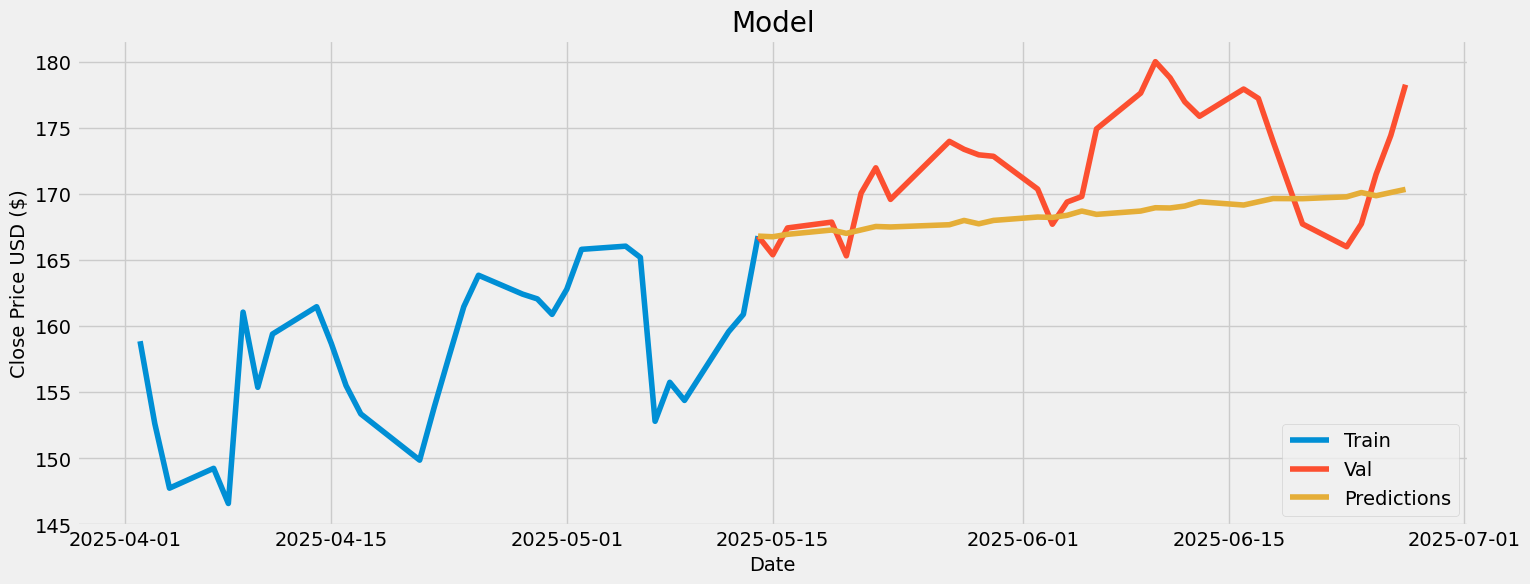

In [13]:
train = data[:-30]
valid = data[-31:].copy()  # コピーを作成 グラフをつなげるために31日前からのデータ
valid['Predictions'] = future_preds

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'][-30:], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

## --- 1) 予測結果の評価 ---  
方向性一致率（今回の結果56.68%）を見ると、この50を超えた +6.68% は投資において大きなリードとなる可能性がある。  
アンサンブルの材料としては十分すぎる結果である。  
    
epochが想定（100程度）より少なくていいということは意外な発見だった。  

# 2) Bidirectional LSTM + Attention
#### モデル概略：  
- Bidirectional LSTM により前後のデータから推移を学習
- 複数特徴量を入力可能（例：終値、移動平均、出来高など）
- Attention機構 による重要な時点の強調
- Attentionレイヤーを可視化して「モデルがどの時点に注目して予測を行ったか」を確認可能にする
  
### Attentionの効果  
作成したAttention層は、時間軸方向の重み付けを学習し、重要なタイムステップに集中できるようになる。これはニュースやイベントなどの「特定時点の影響が強い」金融時系列に有効である。  
  
このモデルをまとめると、LSTMの強み（時系列モデリング）に加えて、Bidirectionalで双方向の文脈を考慮し、Attentionで重要タイムステップを抽出し、DropoutとDenseで汎化性能を高めたモデルである。

## データの準備  
1)LSTM で使った入力データをそのまま使う  
x_train shape: (2185, 60, 6)  
y_train shape: (2185,)  
x_test shape: (561, 60, 6)  
y_test shape: (561,)

## Bidirectional LSTMモデルとAttentionレイヤーの実装
### Attentionレイヤーについて
LSTMやGRUの出力に使えるような自作のレイヤーであり、keras.layers.Attentionのようにクエリ（query）・キー（key）・バリュー（value）に基づくattentionを計算するものではない。  
#### < 特徴 >
- 時系列データ向けのシンプルなattention
- 各時刻ステップにスカラーの重みを付け、全体の加重平均（コンテキストベクトル）を出力
- 単方向（self-attentionではない）
- スカラー重み（1ユニット）を使ってsoft attentionを実装
- return_attention=Trueでattention weightsを出力（可視化向け）

In [14]:
# Attentionレイヤー（重み出力用）
class AttentionLayer(Layer):
    def __init__(self, return_attention=False, alpha=0.5, **kwargs):
        super().__init__(**kwargs)  # Kerasカスタムレイヤーの内部的な初期化処理を実行
        self.return_attention = return_attention  # Attentionの重み出力をするか否か
        self.alpha = alpha  # 0.0～1.0 のスケーリング係数

    def build(self, input_shape):  # レイヤー内部の学習可能なパラメータ（重みなど）を定義
                                   # 入力を与えると自動で実行
                                   # W（重み行列）, b（バイアス）
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),    # 特徴量の次元数（LSTMの出力次元数）
                                 initializer='glorot_uniform',  # Xavier初期化
                                 trainable=True)                # 学習対象
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),  # 時系列の長さ（タイムステップ数）
                                 initializer='zeros',        # 初期値 0
                                 trainable=True)             # 学習対象
        super().build(input_shape)

    def call(self, x):  # Kerasのカスタムレイヤーで定義するメインの処理関数
                        # __call()__に入れられ、自動で実行
        e = K.tanh(K.dot(x, self.W) + self.b)        # スコア
        a = K.softmax(e, axis=1)                     # 重み（合計1）
        # αでAttentionの影響率を調整（α=1.0なら完全にAttentionに従う）
        weighted_output = x * a                      # 各時刻の出力に重みを乗算
        mean_output = K.mean(x, axis=1, keepdims=True)
        # Attentionの出力を平均ベースの出力とブレンド
        output = self.alpha * weighted_output + (1 - self.alpha) * mean_output
        
        context_vector = K.sum(output, axis=1)       # 重み付き和
        if self.return_attention:
            return [context_vector, a]
        else:
            return context_vector

### Bidirectional LSTMモデルの実装
学習能力が弱かったようなので、Bidirectional LSTMの後にDense層とBatchNormalizationを追加した。  
Total params: 11,661

In [15]:
# モデル定義関数
def create_model_with_attention(seq_len=window_size, num_features=6):
    # 入力の形状（例：60タイムステップ × 特徴量数）
    inputs = Input(shape=(seq_len, num_features))

    # LSTM層（学習安定性を考慮して2層）
    x = Bidirectional(LSTM(32, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    
    # Attentionレイヤー
    context_vector, attention_weights = AttentionLayer(return_attention=True, alpha=0.8)(x)
    # Attentionの正規化
    context_vector = LayerNormalization()(context_vector)

    # Dense層（BatchNorm -> Activation）
    # x = Dense(32)(context_vector)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Dropout(0.2)(x)
    
    output = Dense(1)(context_vector)  # 予測値（1日後の変化率）

    model = Model(inputs=inputs, outputs=output)
    att_model = Model(inputs=inputs, outputs=attention_weights)  # Attention可視化用モデル

    # 最適化：学習率を下げ、勾配爆発防止（clipnorm）
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.summary()
    
    return model, att_model

### モデルとコールバック関数の構築

In [16]:
# モデルの作成
model, att_model = create_model_with_attention()

# コールバック関数
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    start_from_epoch=0,
    verbose=1)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',       # 保存ファイル名
    monitor='val_loss',             # 監視する指標（例：val_loss）
    save_best_only=True,            # 最良のモデルのみ保存（True推奨）
    mode='min',                     # val_lossは小さいほど良いので 'min'
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # val_lossが改善しないとき
    factor=0.5,             # 学習率を半分にする
    patience=10,             # 10エポック改善しなければ
    min_lr=1e-5,            # 最小学習率の下限
    verbose=1
)

callbacks = [early_stop, reduce_lr]


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 60, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ [(None, 50), (None, 60, 1)] │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 50)                  │             100 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,661 (45.55 KB)

 Trainable params: 11,661 (45.55 KB)

 Non-trainable params: 0 (0.00 B)

## モデルの学習の実行
batch_size=16, epochs=10（データをbatch_size分割し実行、それをepochs回繰り返す）

In [17]:
batch_size, epochs = 16, 10

# 学習
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    shuffle=False,  # ← 時系列データでは必須！
    epochs=epochs,
    batch_size=batch_size,
    # callbacks=callbacks,
    verbose=1
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.8480 - val_loss: 2.0368
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7973 - val_loss: 2.0284
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7724 - val_loss: 2.0108
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7544 - val_loss: 2.0204
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.7594 - val_loss: 1.9932
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7455 - val_loss: 2.0080
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7463 - val_loss: 2.0166
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7401 - val_loss: 1.9971
Epoch 9/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7475 - val_loss: 2.0026
Epoch 10/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7456 - val_loss: 2.0185


### 学習したBidirectional LSTMモデルでの予測 
精度確認のため、以下の指標を表示  
- 二乗平均平方根誤差RMSE
- 決定係数R2
- 的中率（誤差が指定範囲以内に収まった率）
- 方向性一致率（変化率の正負が一致した率）

このモデルの出力はアンサンブルの材料（特徴量）なので、的中率・方向性一致率よりRMSE・R2を重視する。

In [18]:
# 予測を実行
predictions = model.predict(x_test)
predicted = returns_scaler.inverse_transform(predictions)
actual = returns_scaler.inverse_transform(y_test.reshape(-1, 1))

# アンサンブルのために、このモデルの結果を preds に保存
preds['BiLSTM'] = predicted
# このモデルの明日予測（データ最終日の翌日）
final_preds['BiLSTM'] = model.predict(final_input)


# 評価指標の計算
m_pred = np.mean(predicted) * 100  # %表示
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# 結果表示
print(f"平均  : {m_pred:.3f}[%]")
# print(f"MAE  : {mae:.4f}")  # 平均絶対誤差: 0に近いほど良い
print(f"RMSE : {rmse:.4f}")  # 二乗平均平方根誤差: 0に近いほど良い
print(f"R²   : {r2:.4f}")    # 決定係数: 1に近いほど良い

# 的中率（独自定義）を求める
# 閾値リスト（パーセンテージ表記）
thresholds = [0.0002, 0.0008, 0.0015]

print("的中率（予測誤差が閾値以内）:")
for threshold in thresholds:
    errors = np.abs(predicted[:, 0] - actual[:, 0])  # 絶対誤差を計算
    hit_mask = errors <= threshold  # 的中条件
    hit_rate = np.mean(hit_mask) * 100  # 的中率（%）を計算
    print(f" ±{threshold*100:.2f}%以内: {hit_rate:.2f}%")

# 予測と実際の符号が一致しているか
same_direction = np.sign(predicted) == np.sign(actual)
directional_accuracy = np.mean(same_direction) * 100

print(f"方向性一致率: {directional_accuracy:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
平均  : 0.203[%]
RMSE : 0.0186
R²   : -0.0048
的中率（予測誤差が閾値以内）:
 ±0.02%以内: 1.42%
 ±0.08%以内: 3.74%
 ±0.15%以内: 6.94%
方向性一致率: 54.09%


## Attentionの可視化
特定の入力に対する注意重み（各タイムステップへの注目度）を表示

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


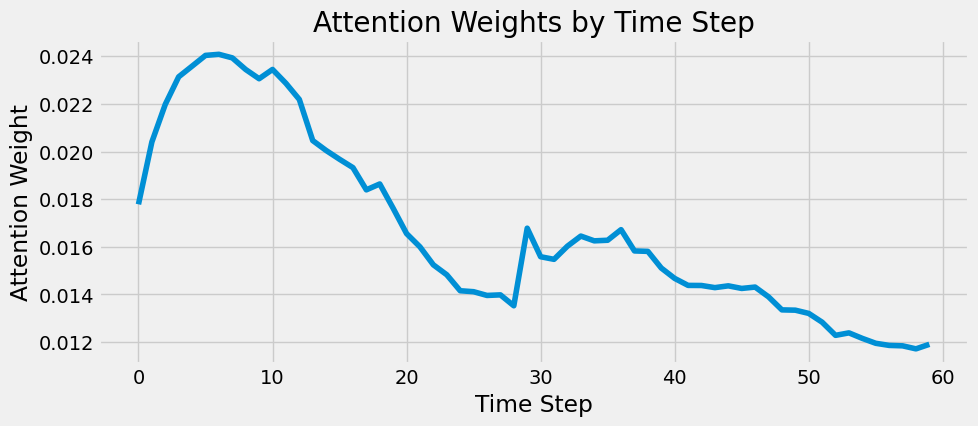

In [19]:
# X_sample: (1, 60, num_features) の1つのサンプルを渡す
day_sample = []
day_sample.append(x_test[300])
X_sample = np.array(day_sample)

attention_weights = att_model.predict(X_sample)

# 可視化
plt.figure(figsize=(10, 4))
plt.plot(attention_weights[0])
plt.title("Attention Weights by Time Step")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.show()

## 30日先までをマルチステップ予測

In [20]:
def predict_future_sequence(model, recent_data, window_size=60, future_days=30):
    """
    model        : 学習済みのLSTMモデル（Keras）
    recent_data  : 正規化された系列データ（scaled）で、shape=(window_size, 1)
    window_size  : モデルの入力シーケンス長（通常は60）
    future_days  : 何日先まで予測するか（通常は30）
    
    戻り値: 予測値のリスト（正規化済）
    """
    predictions = []

    # 予測に使うデータをコピー（書き換えないため）
    input_seq = recent_data.copy()

    for _ in range(future_days):
        # モデルに入力するためshape変換: (1, window_size, x_train.shape[2])
        x_input = np.reshape(input_seq, (1, window_size, x_train.shape[2]))

        # 予測
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0][0])  # スカラー値として保存

        # input_seqを1つシフトして、予測値を末尾に追加
        input_seq = np.append(input_seq[1:], [[pred[0][0]]], axis=0)

    return predictions


# 30日前からさかのぼって60日分（正規化済）のデータを準備
last_60_scaled = feature_data[["returns", "Volume", "MACD_Histogram", "Signal", "RSI9", "RSI14"]][-90:-30].to_numpy().reshape(-1, 1)  # shape=(60, 1)

# 最後の30日をマルチステップ予測
future_returns_scaled = predict_future_sequence(model, last_60_scaled, window_size=60, future_days=30)

# 逆正規化
future_returns = returns_scaler.inverse_transform(np.array(future_returns_scaled).reshape(-1, 1))

# 最後の実際の価格
last_price = dataset.iloc[-31]['Close']

# リターンから株価へ変換
future_preds = [last_price]
for ret in future_returns:
    next_price = future_preds[-1] * (1 + ret[0])
    future_preds.append(next_price)

# 先頭のlast_priceだけは実際の値であることに注意

print(f"起点価格: {last_price:.2f}")
print(f"予測された価格（最初の5日）: {future_preds[:5]}")

起点価格: 166.81
予測された価格（最初の5日）: [166.81, 167.27164263612124, 166.51144997337278, 164.27549796835652, 165.91920254185024]


### 実際の株価とマルチステップ予測値をグラフで比較
実際の株価＝Val  
予測値＝Predictions

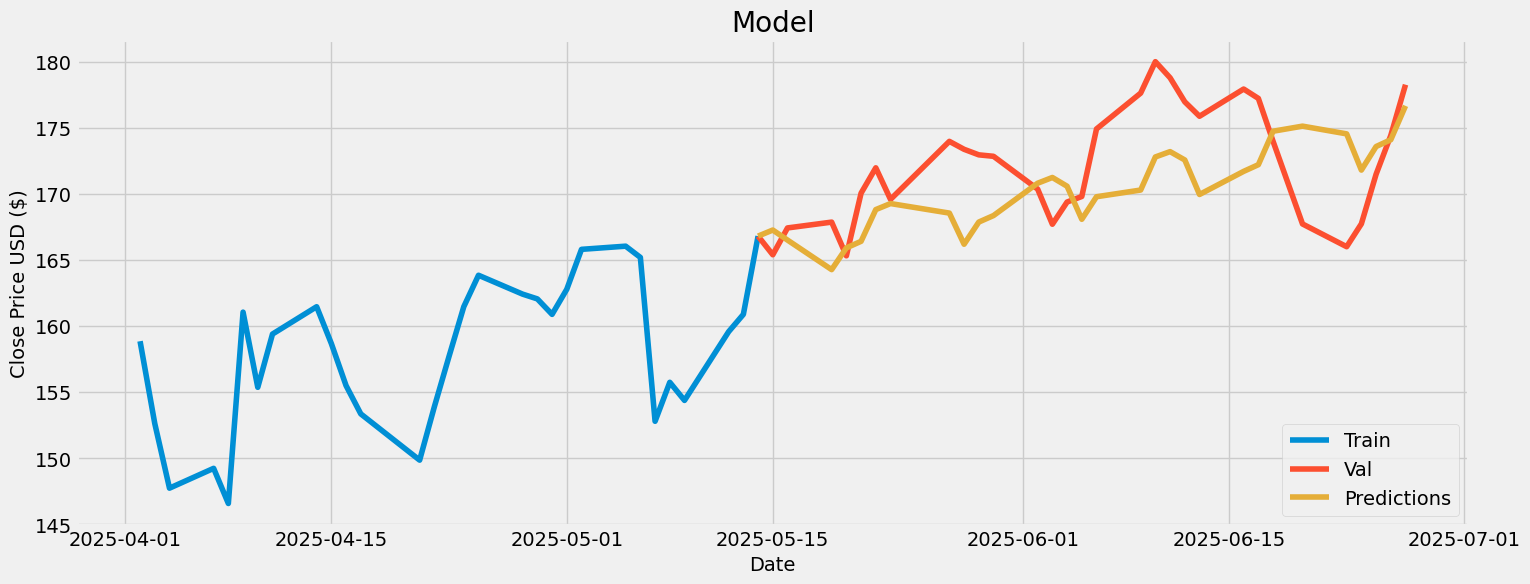

In [21]:
train = data[:-30]
valid = data[-31:].copy()  # コピーを作成 グラフをつなげるために31日前からのデータ
valid['Predictions'] = future_preds

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'][-30:], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

## --- 2) 予測結果の評価 ---  
方向性一致率＝57.04%は理想的な結果。  
データも分散も保てているよう。  
マルチステップ予測のグラフが良い具合に揺れている。  
  
アンサンブルの材料としては良い結果であった。

# 3) Transformer
Transformerベースの標準的な構成  
以下で紹介されているモデルをベースとして、様々な改良を施した。  
https://youtu.be/LNydD9ZemZ8  
https://github.com/samugit83/TheGradientPath/blob/master/Keras/transformers/time_series_forecast/main.py  

  
### モデルの特徴
一番の特徴は、入力から10日後までのマルチステップ予測をコードに入れたことである。  
以下の性質のため、TransformerはLSTMより数日後の予測精度が期待できる。  
- LSTMは「順番に」データを処理するため、過去の情報が遠くなると影響が薄まる（勾配消失問題）
- Transformerは全時点を並列に処理し、任意の2点間の依存関係に直接アクセスできる。

前項までの1), 2)では実験的に精度を度外視した逐次的なマルチステップ予測をしているが、3)では精度に期待できるマルチステップ予測（10日後まで）を実装した。  
#### 重要な変更点！
これまでの1),2)でもそうだが、3)でも予測値の変化が弱くなりすぎる問題が発生してしまった。  
そのため変化が弱すぎることにペナルティを課すカスタム損失関数を定義する。  
  
【その他細部の特徴】
- seq_len=60：過去60日分の入力
- d_model=64：埋め込み後の次元
- Multi‑Head Attention：自己注意によって各ステップの重要な相互関係を学習
- 残差 + LayerNorm により深い学習が安定
- GlobalAveragePooling によって時系列全体から意味ある特徴を抽出
  
#### ここで Transformer, Informer, Autoformer について、特徴を比較しておく。  
  
#### モデル　　　　　入力長	　　　　特徴	　　　　　　おすすめ用途  
基本Transformer	　60〜120　　自己注意による並列処理	　中規模データ / 複数特徴量  
Informer 	　　　　96〜512　　長期依存を捉えやすい　　　長期予測 / 大規模データ  
Autoformer	　　　96〜512　　傾向と周期性の分解　　　　季節性の強い時系列に◎

## データの準備  
引き続き 1)LSTM で使った入力データを使う（日数は日々増えるので概数）  
x_train shape: (2185, 60, 6)  
y_train shape: (2185,)  
x_test shape: (561, 60, 6)  
y_test shape: (561,)  
ここからマルチステップ予測対応のため、正解ラベル y を10日分に拡張する。そのため入力 x の日数も減少する。  
### 予測を数日先にまで拡張するための学習データ作成
変換のための関数を作り、実行する。

In [22]:
# 何日先まで予測するか、ここで決定
future_steps = 10

# 予測を数日先にまで拡張するための学習データを作成する関数
def create_multistep_dataset(X, Y, future_steps=10):
    Xs, Ys = [], []
    for i in range(len(X) - future_steps + 1):  # データ数(len): X,Yは9減る
        Xs.append(X[i])
        Ys.append(Y[i:i+future_steps])
    return np.array(Xs), np.array(Ys)


x_train3, y_train3 = create_multistep_dataset(x_train, y_train, future_steps)
x_test3, y_test3 = create_multistep_dataset(x_test, y_test, future_steps)

# shape 確認（samples, timesteps, features）
print("x_train3 shape:", x_train3.shape)
print("y_train3 shape:", y_train3.shape)
print("x_test3 shape:", x_test3.shape)
print("y_test3 shape:", y_test3.shape)

x_train3 shape: (2180, 60, 6)
y_train3 shape: (2180, 10)
x_test3 shape: (553, 60, 6)
y_test3 shape: (553, 10)


## Transformerモデルの実装

### 【Transformer 簡易モデル】
実験に使おうと思っていたモデルだが、もう少し高精度なものを使うことにした。一応コードを残す。

In [23]:
# def build_transformer_model(seq_len=60, num_features=5, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
#     inputs = Input(shape=(seq_len, num_features))
#     x = Dense(d_model)(inputs)  # 埋め込み次元へ変換
    
#     # Encoder層
#     attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
#     attn_out = Dropout(dropout)(attn_out)
#     x = LayerNormalization()(x + attn_out)  # 残差接続 + 正規化
    
#     ff = Dense(ff_dim, activation="relu")(x)
#     ff = Dense(d_model)(ff)
#     ff = Dropout(dropout)(ff)
#     x = LayerNormalization()(x + ff)
    
#     x = GlobalAveragePooling1D()(x)  # 時系列平均
#     x = Dropout(dropout)(x)
#     outputs = Dense(1)(x)  # 次日株価予測
    
#     model = Model(inputs, outputs)
#     model.compile(optimizer="adam", loss="mse")
#     return model

# model = build_transformer_model(seq_len=60, num_features=5)
# model.summary()

### 【Transformer 高精度モデル】
- 位置エンコーディングの追加  
PositionalEncoding を追加し、Transformerが時系列順を理解できるようにしています。
- マルチステップ予測  
単一ステップ（翌日）予測から、複数日先（例：10日先まで）の予測に対応。
- カスタムMultiHeadSelfAttentionとTransformerBlock  
内部でクエリ、キー、バリューを計算し、スケーリングとヘッドの結合まで処理。
- GlobalAveragePoolingの利用  
系列情報を平均的に集約する手法で過学習を抑制。

### カスタム損失関数の定義
#### 変化が弱すぎることにペナルティを課すカスタム損失関数を定義する  
alpha=0.005,　　: バッチ全体の翌日予測の分散ペナルティ  
beta=0,　　　　 : バッチ全体の翌日予測の差分ペナルティ  
gamma=0.005,　: サンプルごとの分散と予測値の分散を近づける  
delta=0　　　　 : サンプルごとの予測内の差分ペナルティ

In [24]:
def custom_loss_combined(y_true, y_pred,
                         alpha=0.005,  # バッチ全体のt+1予測の分散ペナルティ
                         beta=0,       # バッチ全体のt+1予測の差分ペナルティ
                         gamma=0.005,  # サンプルごとの分散と予測値の分散を近づける
                         delta=0       # サンプルごとの予測内の差分ペナルティ
                        ):
    # MSE（基本損失）
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

    # バッチ全体の t+1 予測の分散が小さすぎる場合のペナルティ
    t1_preds = y_pred[:, 0]
    t1_variance = tf.math.reduce_variance(t1_preds)
    global_var_penalty = 1.0 / (t1_variance + 1e-6)

    # バッチ内の t+1 予測値の差分（連続する予測間の差）が小さすぎる場合のペナルティ
    t1_diffs = t1_preds[1:] - t1_preds[:-1]
    t1_diff_penalty = 1.0 / (tf.reduce_mean(tf.square(t1_diffs)) + 1e-6)    

    # 各サンプル内の予測と正解の分散一致ペナルティ
    var_true = tf.math.reduce_variance(y_true, axis=-1)
    var_pred = tf.math.reduce_variance(y_pred, axis=-1)
    var_penalty = tf.abs(var_true - var_pred)

    # 各サンプル内での予測値の差分（変化が小さすぎると罰する）
    delta_pred = y_pred[:, 1:] - y_pred[:, :-1]
    delta_penalty = tf.reduce_mean(tf.square(delta_pred), axis=-1)
    variation_penalty = 1.0 / (delta_penalty + 1e-6)

    # 合計損失
    global_loss = alpha * global_var_penalty + beta * t1_diff_penalty
    batch_loss = tf.reduce_mean(mse + gamma * var_penalty + delta * variation_penalty)
    total_loss = global_loss + batch_loss

    # ペナルティ項同士のバランスを訓練中にモニター
    # tf.print("MSE:", mse)
    # tf.print("Global Var Penalty:", global_var_penalty)
    # tf.print("T1 Diff Penalty:", t1_diff_penalty)
    # tf.print("Var Penalty:", var_penalty)
    # tf.print("Variation Penalty:", variation_penalty)
    
    return total_loss

### Transformerモデルの構築
#### embed_dim は num_heads の倍数にすること！！
Total params: 200,522

In [25]:
def build_simple_transformer(seq_len=60, num_features=6,
                             embed_dim=64, num_heads=4, ff_dim=256,
                             num_layers=2, dropout=0.2, future_steps=10):
    
    inputs = layers.Input(shape=(seq_len, num_features))

    # 1. 線形埋め込み
    x = layers.Dense(embed_dim)(inputs)

    # 2. 位置エンコーディング（Embeddingではなく単純な加算）
    positions = tf.range(start=0, limit=seq_len, delta=1)
    # Transformerは 時系列の順番を考慮しない構造なので、位置情報を Embeddingで明示的に加える（これが位置エンコーディング）
    position_embedding = layers.Embedding(input_dim=seq_len, output_dim=embed_dim)(positions)
    x += position_embedding

    # 3. Transformer Encoder Blocks
    res_scale = 0.6  # 残差接続の際のスケーリング係数
    for _ in range(num_layers):
        # Multi-Head Self-Attention + 残差 + LayerNorm
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + res_scale * attn_output)
        # Feed-forward + 残差 + LayerNorm
        ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        ffn_output = ffn(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + res_scale * ffn_output)

    # 4. プーリングと出力
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(future_steps)(x)  # ← マルチステップ出力

    model = models.Model(inputs, outputs)
    
    # 最適化：学習率を下げ、勾配爆発防止（clipnorm）
    optimizer = Adam(learning_rate=0.00005, clipnorm=1.0)
    
    model.compile(
        optimizer=optimizer,
        # カスタム損失関数のパラメータ設定
        loss=lambda y_true, y_pred: custom_loss_combined(
            y_true, y_pred,
            alpha=0.005, beta=0, gamma=0.005, delta=0
        ),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

### 学習と学習履歴の視覚化、予測実行をする関数
train_and_evaluate()  
#### カスタマイズ可能な引数
- embed_dim（埋め込み次元）
- num_heads（Attentionヘッド数）
- ff_dim（Feedforward層の隠れ次元）
- num_layers（Encoderブロックの数）
- dropout（Dropout率）
- batch_size, epochs, future_steps

In [26]:
def train_and_evaluate(x_train, y_train, x_test, y_test,
                       seq_len=60, num_features=6,
                       embed_dim=64, num_heads=4, ff_dim=256,
                       num_layers=2, dropout=0.2,
                       batch_size=16, epochs=20, future_steps=10):

    model = build_simple_transformer(
        seq_len=seq_len,
        num_features=num_features,
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_layers=num_layers,
        dropout=dropout,
        future_steps=future_steps
    )

    model.summary()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        start_from_epoch=60,
        verbose=1
    )

    history = model.fit(
        x_train, y_train,
        validation_split=0.1,
        shuffle=False,  # ← 時系列データでは必須！
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    # 評価
    eval_results = model.evaluate(x_test, y_test)
    print(f"\nTest Loss (MSE): {eval_results[0]:.4f}")
    print(f"MAE: {eval_results[1]:.4f}")
    print(f"RMSE: {eval_results[2]:.4f}")

    # 予測
    predictions = model.predict(x_test)

    # 学習履歴プロット
    # plt.plot(history.history['loss'], label='Train Loss')
    # plt.plot(history.history['val_loss'], label='Val Loss')
    # plt.title('Training & Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return model, history, predictions

## モデルの学習と予測の実行
batch_size=16, epochs=15（データをbatch_size分割し実行、それをepochs回繰り返す）

In [27]:
model, history, predictions = train_and_evaluate(
    x_train3, y_train3, x_test3, y_test3,
        seq_len=x_train.shape[1], num_features=x_train.shape[2],  # 60, 6
    batch_size=16, epochs=15, future_steps=future_steps)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 60, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 60, 64)         │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 60, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 64)         │         66,368 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 60, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 60, 64)         │              0 │ add[0][0],             │
│                           │                        │                │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 60, 64)         │         33,088 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 60, 64)         │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 60, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 60, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 60, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 60, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 60, 64)         │              0 │ layer_normalization_2… │
│                           │                        │                │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 60, 64)         │            128 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 200,522 (783.29 KB)

 Trainable params: 200,522 (783.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - loss: 1.1798 - mae: 0.7933 - root_mean_squared_error: 1.0743 - val_loss: 8.9077 - val_mae: 1.0853 - val_root_mean_squared_error: 1.4287
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.9835 - mae: 0.7042 - root_mean_squared_error: 0.9759 - val_loss: 18.7222 - val_mae: 1.0811 - val_root_mean_squared_error: 1.4203
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.9444 - mae: 0.6846 - root_mean_squared_error: 0.9528 - val_loss: 22.3427 - val_mae: 1.0747 - val_root_mean_squared_error: 1.4161
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.9094 - mae: 0.6612 - root_mean_squared_error: 0.9312 - val_loss: 18.9230 - val_mae: 1.0763 - val_root_mean_squared_error: 1.4170
Epoch 5/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.8845 - mae: 0.6506 - root_mean_squared_error: 0.9161 - val_loss: 22.4787 - val_mae: 1.0722 - val_root_mean_squared_error: 1.4141
Epoch 6/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 

## Transformerモデルでの予測を評価する 
精度確認のため、以下の指標を表示  
- 二乗平均平方根誤差RMSE
- 決定係数R2
- 的中率（誤差が指定範囲以内に収まった率）
- 方向性一致率（変化率の正負が一致した率）

このモデルの出力はアンサンブルの材料（特徴量）なので、的中率・方向性一致率よりRMSE・R2を重視する。

In [28]:
# 正規化を逆変換
predicted = returns_scaler.inverse_transform(predictions)
actual = returns_scaler.inverse_transform(y_test3.reshape(-1, future_steps))

# アンサンブルのために、このモデルの結果を preds に保存
p = predicted[:, 0]
p = np.append(p, predicted[-1, 1:])
preds['Transformer'] = p
# このモデルの明日予測（データ最終日の翌日）
f_p = model.predict(final_input)
final_preds['Transformer'] = f_p[0, 0]
future_10days = f_p[0]  # 10日先のデータを参考として保存


print("----- まずは翌日予測の精度を確認 -----")
# 評価指標の計算
pred_mean = np.mean(predicted[:, 0]) * 100  # %表示
mse = mean_squared_error(actual[:, 0], predicted[:, 0])
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual[:, 0], predicted[:, 0])
r2 = r2_score(actual[:, 0], predicted[:, 0])

# 結果表示
print(f"平均  : {pred_mean:.3f}[%]")
# print(f"MAE  : {mae:.4f}")  # 平均絶対誤差: 0に近いほど良い
print(f"RMSE : {rmse:.4f}")  # 二乗平均平方根誤差: 0に近いほど良い
print(f"R²   : {r2:.4f}")    # 決定係数: 1に近いほど良い

# 的中率（独自定義）を求める
# 閾値リスト（パーセンテージ表記）
thresholds = [0.0002, 0.0008, 0.0015]

print("的中率（予測誤差が閾値以内）:")
for threshold in thresholds:
    errors = np.abs(predicted[:, 0] - actual[:, 0])  # 絶対誤差を計算
    hit_mask = errors <= threshold  # 的中条件
    hit_rate = np.mean(hit_mask) * 100  # 的中率（%）を計算
    print(f" ±{threshold*100:.2f}%以内: {hit_rate:.2f}%")

# 予測と実際の符号が一致しているか
same_direction = np.sign(predicted[:, 0]) == np.sign(actual[:, 0])
directional_accuracy = np.mean(same_direction) * 100

print(f"方向性一致率: {directional_accuracy:.2f}%")

print("\n----- 次に10日先の予測の精度を確認 -----")
# 評価指標の計算
pred_mean = np.mean(predicted[:, 9]) * 100  # %表示
mse = mean_squared_error(actual[:, 9], predicted[:, 9])
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual[:, 9], predicted[:, 9])
r2 = r2_score(actual[:, 9], predicted[:, 9])

# 結果表示
print(f"平均  : {pred_mean:.3f}[%]")
# print(f"MAE  : {mae:.4f}")  # 平均絶対誤差: 0に近いほど良い
print(f"RMSE : {rmse:.4f}")  # 二乗平均平方根誤差: 0に近いほど良い
print(f"R²   : {r2:.4f}")    # 決定係数: 1に近いほど良い

print("的中率（予測誤差が閾値以内）:")
for threshold in thresholds:
    errors = np.abs(predicted[:, 9] - actual[:, 9])  # 絶対誤差を計算
    hit_mask = errors <= threshold  # 的中条件
    hit_rate = np.mean(hit_mask) * 100  # 的中率（%）を計算
    print(f" ±{threshold*100:.2f}%以内: {hit_rate:.2f}%")

# 予測と実際の符号が一致しているか
same_direction = np.sign(predicted[:, 9]) == np.sign(actual[:, 9])
directional_accuracy = np.mean(same_direction) * 100

print(f"方向性一致率: {directional_accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
----- まずは翌日予測の精度を確認 -----
平均  : 0.271[%]
RMSE : 0.0187
R²   : -0.0127
的中率（予測誤差が閾値以内）:
 ±0.02%以内: 0.72%
 ±0.08%以内: 3.62%
 ±0.15%以内: 7.41%
方向性一致率: 54.97%

----- 次に10日先の予測の精度を確認 -----
平均  : 0.308[%]
RMSE : 0.0188
R²   : -0.0305
的中率（予測誤差が閾値以内）:
 ±0.02%以内: 1.45%
 ±0.08%以内: 4.52%
 ±0.15%以内: 6.87%
方向性一致率: 55.15%


上記は furtur_steps = 10 の結果  
furtur_steps = 1 で実験してみたところ、翌日予測の方向性一致率: 55.18%となった。  
furtur_steps の値が大きくなると翌日予測の精度が下がるかと思ったが、他の評価指標を見てもそれほど下がっていなかった。

# 実際の株価と10日先までの予測値をグラフで比較
実際の株価＝Val  
予測値＝Predictions

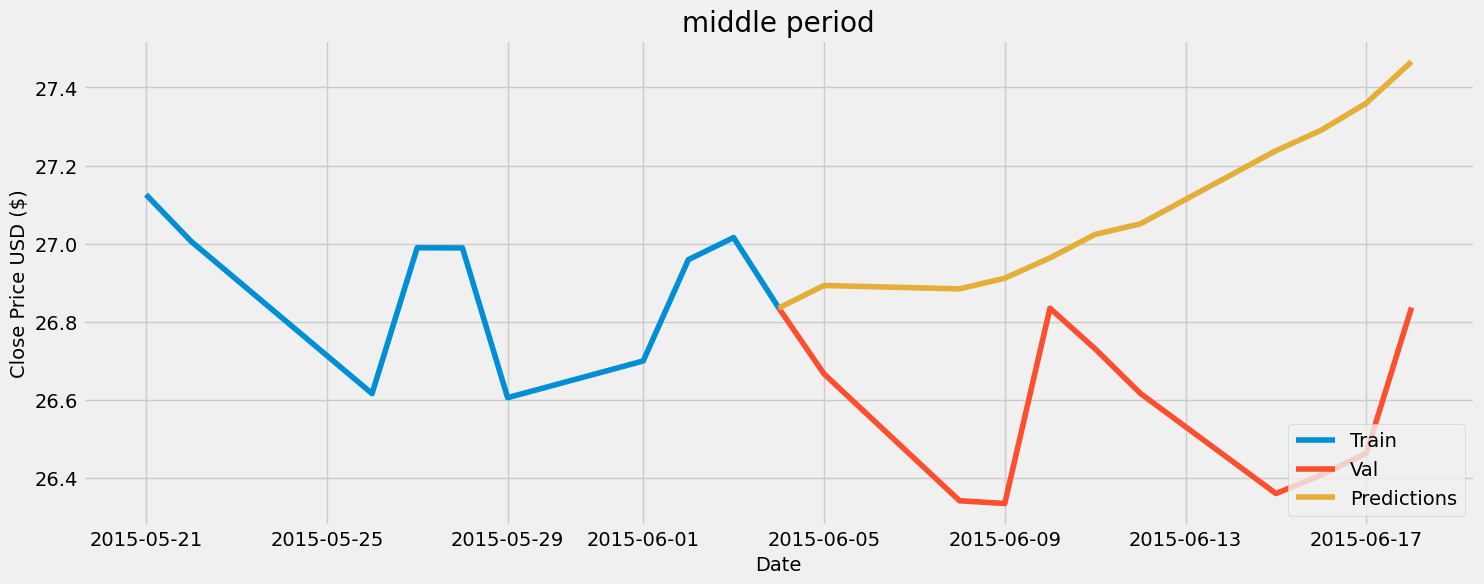

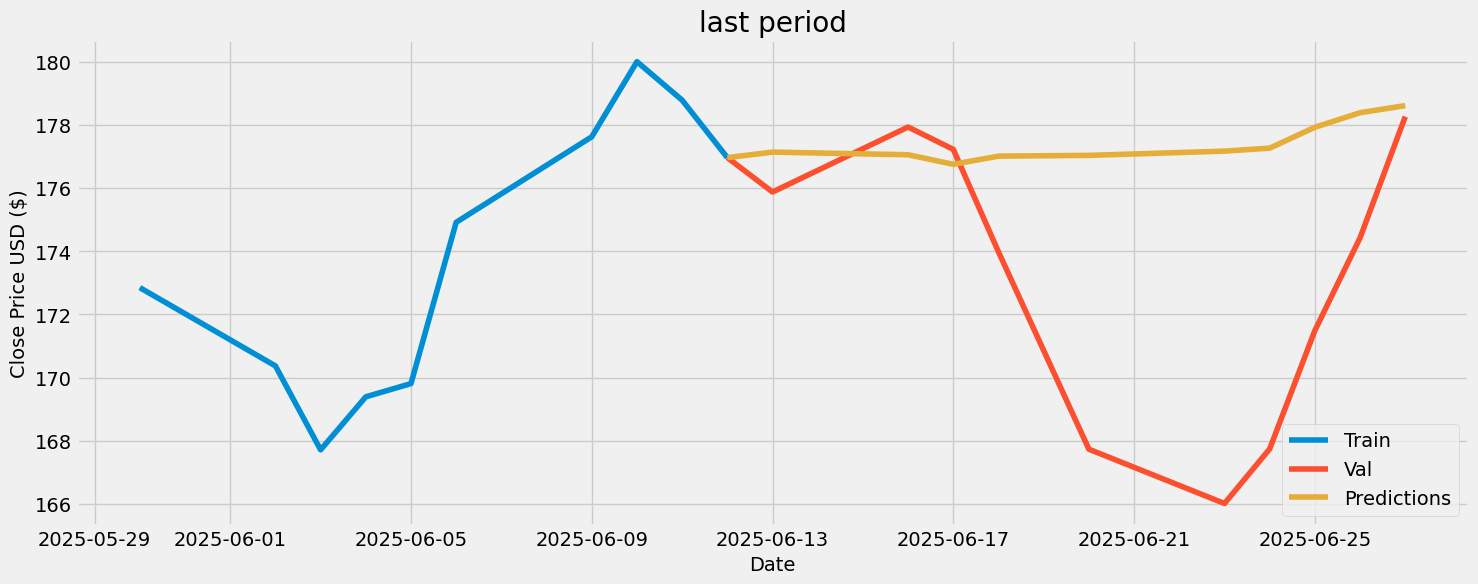

In [29]:
train = data[:300]         # ラスト10日のグラフに予測値のグラフを重ねる
valid = data[299:310].copy()  # コピーを作成 グラフをつなげるために11日前からのデータ
# 11日前のデータにリターンを次々と掛けて、ラスト10日の予測値を求める
valid['Predictions'] = valid['Close']
for i in range(10):
    valid.iloc[i+1, -1] = valid.iloc[i, -1] * (1 + predicted[300, i])

plt.figure(figsize=(16, 6))
plt.title('middle period')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'][-10:], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

train = data[:-10]         # ラスト10日のグラフに予測値のグラフを重ねる
valid = data[-11:].copy()  # コピーを作成 グラフをつなげるために11日前からのデータ
# 11日前のデータにリターンを次々と掛けて、ラスト10日の予測値を求める
valid['Predictions'] = valid['Close']
for i in range(10):
    valid.iloc[i+1, -1] = valid.iloc[i, -1] * (1 + predicted[-1, i])

plt.figure(figsize=(16, 6))
plt.title('last period')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'][-10:], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

## --- 3) 予測結果の評価 ---  
方向性一致率＝55.72%についてはまずまずの結果が出た。  
ただ予測値の分散が極端に低くなるという結果が出てしまったが、これについては次のアンサンブル段階で上昇or下降の２分類出力を計画しているため、問題視しない。  
この段階で分散を保つペナルティを強くすると、学習が安定しない。  
  
アンサンブルの材料としては良い結果であった。

# 6) アンサンブル学習による明日予測
### 最後に５つのモデル（２つは未実装）の予測をrandom forestを使ってアンサンブルする。  
RandomForestClassifierを使い、５つのモデルの予測からデータ最終日の翌日の変化率が＋となる確率を求める。  
RandomForestClassifierのパラメータはかなり弱めの設定にする。  
LSTM, BidirectionalLSTM, Transformerのどのモデルが予測に貢献したかを示すFeature Importanceも表示する。

Accuracy: 0.7758007117437722
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.55      0.68       250
           1       0.73      0.96      0.83       312

    accuracy                           0.78       562
   macro avg       0.82      0.75      0.76       562
weighted avg       0.81      0.78      0.76       562




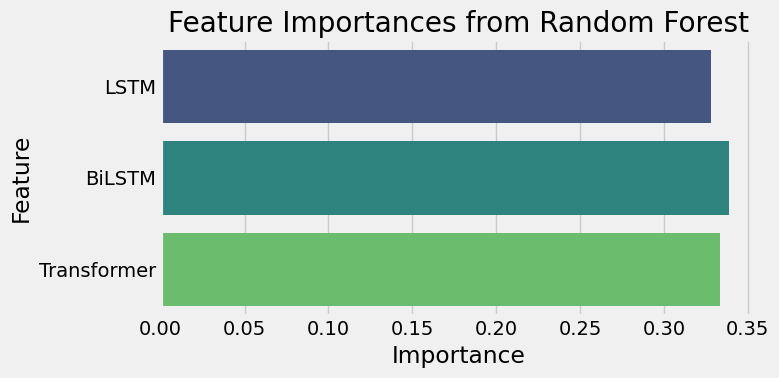

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# 1. ターゲット（returns）をバイナリ分類に変換：正->1、負または0->0
binary_returns = (returns > 0).astype(int)

# 2. Random Forest のパラメータ設定
params = {
    'random_state': 10,
    'n_estimators': 26,
    'max_depth': 6,
    'max_features': 'sqrt',
}

# 3. モデル学習
clf = RandomForestClassifier(**params)
clf.fit(preds, binary_returns)

# 4. 精度評価（任意）
pred_labels = clf.predict(preds)
print("Accuracy:", accuracy_score(binary_returns, pred_labels))
print("Classification Report:\n", classification_report(binary_returns, pred_labels))

# 5. 翌日の +リターンの確率を出力
positive_return_prob = clf.predict_proba(final_preds)[0][1]
print("")
display(HTML(f'<h1 style="color:red;">翌日の＋リターンの確率： {positive_return_prob:.2%}</h2>'))
print("")

# 6. Feature Importance の可視化
importances = clf.feature_importances_
feature_names = preds.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### ついでにアンサンブルでリターン値の予測もしておく
RandomForestRegressorを使用し、上と同様にかなり弱めのパラメータを使う

In [31]:
from sklearn.ensemble import RandomForestRegressor

# --- RandomForestのハイパーパラメータ ---
params = {
    'random_state': 10,
    'n_estimators': 26,
    'max_depth': 6,
    'max_features': 'sqrt',
}

# --- モデルの学習 ---
rf_model = RandomForestRegressor(**params)
rf_model.fit(preds, returns)

# --- 最終日の予測 ---
final_prediction = rf_model.predict(final_preds)[0]

# 結果表示（オプション）
display(HTML(f'<h1 style="color:darkblue;">翌日の変化率　予測値： {final_prediction:.2%}</h2>'))